In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import re
import pickle
from time import time
import tensorflow as tf
import collections
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import concatenate

In [2]:
!ls

Image Captioning Project.ipynb
Image captioning.ipynb
archive (7).zip
captions.txt
description_1.txt
descriptions_1.txt
flickr8k.rar
glove.6B.50d.txt
images
model_weights
saved
storage


In [3]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [4]:
captions = readTextFile("C:/Users/User/Downloads/Image-Captioning/New folder/flickr8k/captions.txt")
captions = captions.split('\n')[1:-1]

In [5]:
description ={}
for x in captions:
    first,second = x[:25],x[25:]
    img_name = first.split(".")[0]
    print(first,second)
    if description.get(img_name) is None:
        description[img_name]= []
    description[img_name].append(second)

1000268201_693b08cb0e.jpg ,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg ,A girl going into a wooden building .
1000268201_693b08cb0e.jpg ,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg ,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg ,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg ,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg ,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg ,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg ,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg ,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg ,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jp

In [6]:
description["1000268201_693b08cb0e"]

[',A child in a pink dress is climbing up a set of stairs in an entry way .',
 ',A girl going into a wooden building .',
 ',A little girl climbing into a wooden playhouse .',
 ',A little girl climbing the stairs to her playhouse .',
 ',A little girl in a pink dress going into a wooden cabin .']

In [7]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [8]:
clean_text(',A child in a pink dress is climbing up a set of stairs in an entry way .')

'child in pink dress is climbing up set of stairs in an entry way'

In [9]:
image_list = []
for key,caption_list in description.items():
    image_list.append(key)
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [10]:
image_list

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a',
 '101654506_8eb26cfb60',
 '101669240_b2d3e7f17b',
 '1016887272_03199f49c4',
 '1019077836_6fc9b15408',
 '1019604187_d087bf9a5f',
 '1020651753_06077ec457',
 '1022454332_6af2c1449a',
 '1022454428_b6b660a67b',
 '1022975728_75515238d8',
 '102351840_323e3de834',
 '1024138940_f1fefbdce1',
 '102455176_5f8ead62d5',
 '1026685415_0431cbf574',
 '1028205764_7e8df9a2ea',
 '1030985833_b0902ea560',
 '103106960_e8a41d64f8',
 '103195344_5d2dc613a3',
 '103205630_682ca7285b',
 '1032122270_ea6f0beedb',
 '1032460886_4a598ed535',
 '1034276567_49bb87c51c',
 '104136873_5b5d41be75',
 '1042020065_fb3d3ba5ba',
 '1042590306_95dea0916c',
 '1045521051_108ebc19be',
 '1048710776_bb5b0a5c7c',
 '1052358063_eae6744153',
 '105342180_4d4a40b47f',
 '1053804096_ad278b25

In [11]:
with open("description_1.txt","w") as f:
    f.write(str(description))

In [12]:
total_words = [ ]

for key in description.keys():
    [total_words.append(i) for des in description[key] for i in des.split()]

In [13]:
counter = collections.Counter(total_words)

In [14]:
freq_cnt = dict(counter)

In [15]:
sorted_freq_counter = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_counter = [x for x in sorted_freq_counter if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_counter]

In [16]:
len(image_list)

8091

In [17]:
train = image_list[:6091]
test = image_list[6091:]

In [18]:
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in description[img_id]:
        cap_to_append = "startseq "+ cap +" endseq"
        train_description[img_id].append(cap_to_append)

In [19]:
train_description['1042590306_95dea0916c']

['startseq man and woman pose for the camera while another man looks on endseq',
 'startseq man is holding the hand of woman up to his mouth in front of some buildings while another man looks on endseq',
 'startseq multiracial couple posing for picture endseq',
 'startseq asian man and blond woman holding hands outdoors man in background watches endseq',
 'startseq guy in blue shirt biting hand of girl in black striped jacket while another guy watches endseq']

In [20]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

In [21]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [22]:
model_new = Model(model.input,model.layers[-2].output)

In [23]:
def preProcess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    return img

In [24]:
def encode_imag(img):
    img = preProcess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [25]:
start = time()
encoding_train = {}
for ix,img_id in enumerate(train):
    img_path = "C:/Users/User/Downloads/Image-Captioning/New folder/flickr8k/images/"+img_id+".jpg"
    encoding_train[img_id]=encode_imag(img_path)
    if ix%100 == 0:
        print("Encoding in Progress Time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 1s 820ms/step
Encoding in Progress Time step 0 
1/1 [==============================] - 0s 66ms/step
Encoding in Progress Time step 100 
1/1 [==============================] - 0s 71ms/step
Encoding in Progress Time step 200 
1/1 [==============================] - 0s 70ms/step
Encoding in Progress Time step 300 
1/1 [==============================] - 0s 75ms/step
Encoding in Progress Time step 400 
1/1 [==============================] - 0s 73ms/step
Encoding in Progress Time step 500 
1/1 [==============================] - 0s 80ms/step
Encoding in Progress Time step 600 
1/1 [==============================] - 0s 76ms/step
Encoding in Progress Time step 700 
1/1 [==============================] - 0s 77ms/step
Encoding in Progress Time step 800 
1/1 [==============================] - 0s 74ms/step
Encoding in Progress Time step 900 
1/1 [==============================] - 0s 75ms/step
Encoding in Progress Time step 1000 
1/1 [===========================

In [26]:
!mkdir saved

A subdirectory or file saved already exists.


In [27]:
with open('./saved/encoded_train.pkl',"wb") as f:
    pickle.dump(encoding_train,f)

In [28]:
start = time()
encoding_test = {}
for ix,img_id in enumerate(test):
    img_path = "C:/Users/User/Downloads/Image-Captioning/New folder/flickr8k/images/"+img_id+".jpg"
    encoding_test[img_id]=encode_imag(img_path)
    if ix%100 == 0:
        print("Test Encoding in Progress Time step %d "%ix)

end_t = time()
print("Total Time Taken(test) :",end_t-start)

1/1 [==============================] - 0s 73ms/step
Test Encoding in Progress Time step 0 
1/1 [==============================] - 0s 73ms/step
Test Encoding in Progress Time step 100 
1/1 [==============================] - 0s 69ms/step
Test Encoding in Progress Time step 200 
1/1 [==============================] - 0s 72ms/step
Test Encoding in Progress Time step 300 
1/1 [==============================] - 0s 84ms/step
Test Encoding in Progress Time step 400 
1/1 [==============================] - 0s 76ms/step
Test Encoding in Progress Time step 500 
1/1 [==============================] - 0s 76ms/step
Test Encoding in Progress Time step 600 
1/1 [==============================] - 0s 73ms/step
Test Encoding in Progress Time step 700 
1/1 [==============================] - 0s 71ms/step
Test Encoding in Progress Time step 800 
1/1 [==============================] - 0s 100ms/step
Test Encoding in Progress Time step 900 
1/1 [==============================] - 0s 89ms/step
Test Encoding in Pr

In [29]:
with open('./saved/encoded_test.pkl',"wb") as f:
    pickle.dump(encoding_test,f)

In [30]:
word_to_idx ={}
idx_to_word = {}

In [31]:
for i,words in enumerate(total_words):
    word_to_idx[words] = i+1
    idx_to_word[i+1]= words

In [32]:
idx_to_word[len(total_words)+1] = "startseq"
word_to_idx["startseq"] = len(total_words)+1

In [33]:
idx_to_word[len(total_words)+2] = "endseq"
word_to_idx["endseq"] = len(total_words)+2

vocab_size = len(word_to_idx) + 1
print(vocab_size)

1849


In [34]:
max_len = 0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))

In [35]:
print(max_len)

35


In [36]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)] , np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [37]:
f = open("glove.6B.50d.txt",encoding='utf-8')

In [38]:
embedding_index ={}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding

In [39]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [40]:
f.close()

In [41]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [42]:
embedding_matrix = get_embedding_matrix()

In [43]:
embedding_matrix.shape

(1849, 50)

In [44]:
input_img_features = Input(shape=(2048,))
inp_img1 =Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [45]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [46]:
from tensorflow.keras.layers import concatenate

In [47]:
decoder1 = concatenate([inp_img2,inp_cap3])
decoder2 = Dense(256,activation ='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

f_model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [48]:
f_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92450       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [49]:
f_model.layers[2].set_weights([embedding_matrix])
f_model.layers[2].trainable =False

In [50]:
f_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

In [51]:
f_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92450       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [52]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size

In [53]:
for i in range(epochs):
    generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)

    f_model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    f_model.save('./model_weights/model_'+str(i)+'.h5')

C:\Users\User\AppData\Local\Temp\ipykernel_9188\3501582393.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  f_model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


2030/2030 [==============================] - 225s 111ms/step - loss: 2.5707


In [54]:
with open('./saved/word_to_idx.pkl',"wb") as f:
    pickle.dump(word_to_idx,f)

In [55]:
with open('./saved/idx_to_word.pkl',"wb") as f:
    pickle.dump(idx_to_word,f)

In [63]:
def predict_caption(photo):

    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = f_model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 7ms/step


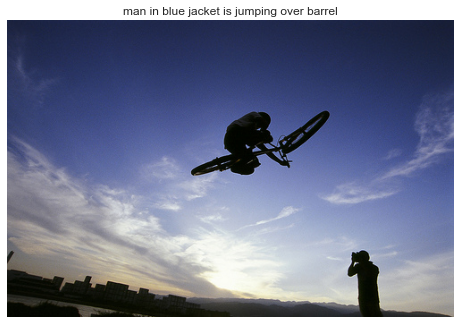

1/1 [==============================] - 0s 16ms/step


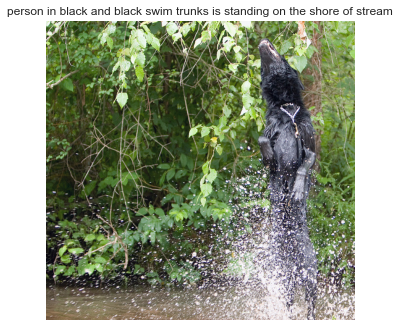

1/1 [==============================] - 0s 16ms/step


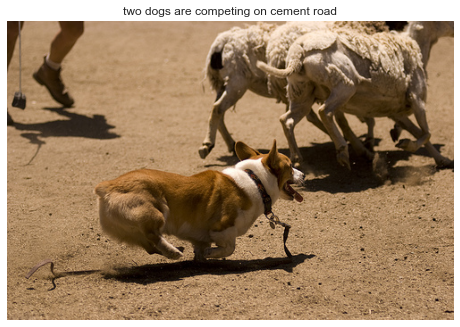

1/1 [==============================] - 0s 16ms/step


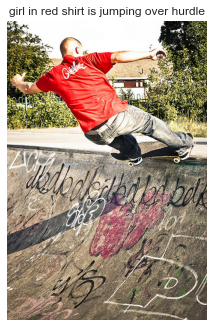

1/1 [==============================] - 0s 8ms/step


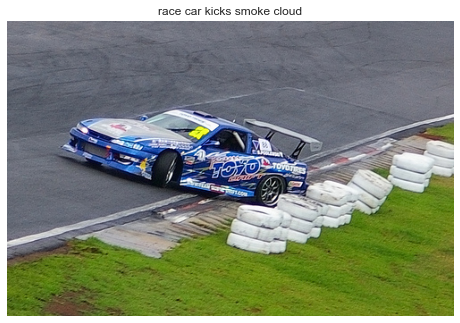

1/1 [==============================] - 0s 22ms/step


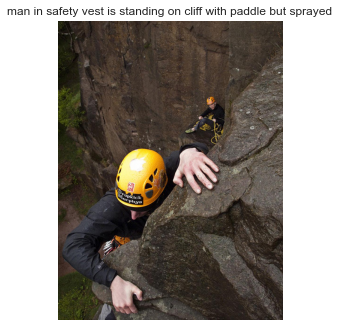

1/1 [==============================] - 0s 16ms/step


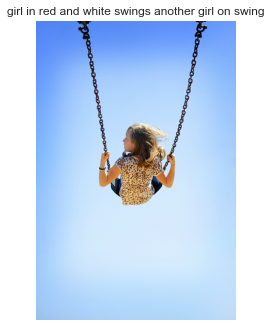

1/1 [==============================] - 0s 16ms/step


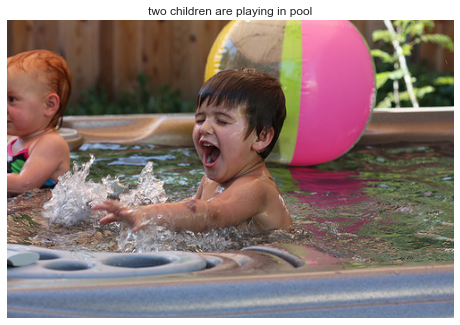

1/1 [==============================] - 0s 16ms/step


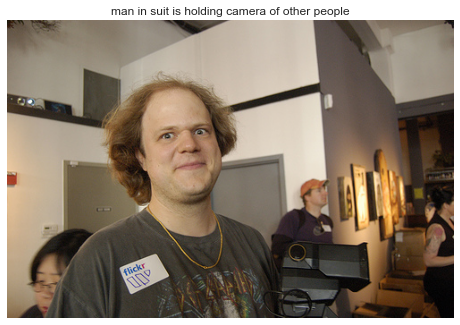

1/1 [==============================] - 0s 22ms/step


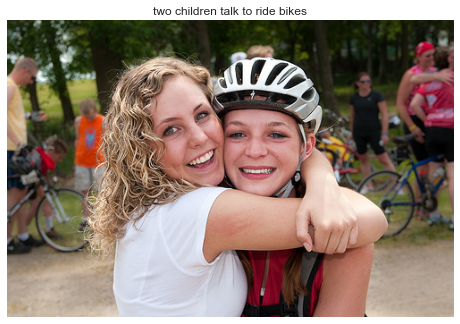

1/1 [==============================] - 0s 13ms/step


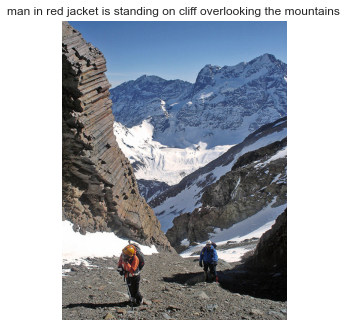

1/1 [==============================] - 0s 16ms/step


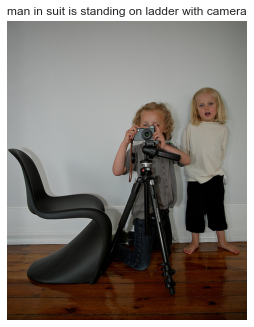

1/1 [==============================] - 0s 16ms/step


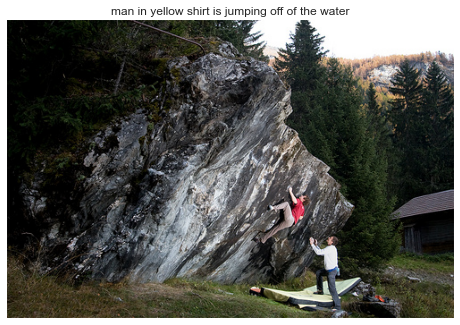

1/1 [==============================] - 0s 7ms/step


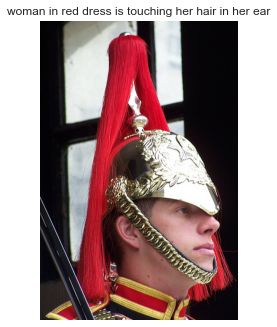

1/1 [==============================] - 0s 7ms/step


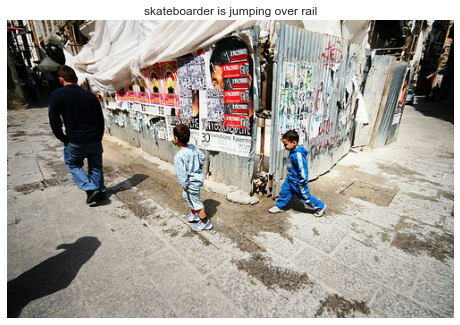

In [64]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = test[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("C:/Users/User/Downloads/Image-Captioning/New folder/flickr8k/images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()